# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

"super small projects"

In [5]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn_col_compressor import compress_colours

from C4_preprocess_imgs import get_cropped_ROIs
from C4_helper import DataLoader, get_bbox, grabcut_algorithm, get_compressed_ROIs

all_data_dir = './cats/'
data_dir = './cats/CAT_00'
# img_ROIs_file = 'cat00_ROI_nps.npy'

img_ROIs_file = 'CAT_00_1xComp_ROIs.npy'
#'toy300range255_CAT_00_1xComp_ROIs.npy'  #use these
# '00_toy_smallsize_16cols.npy'

ImportError: cannot import name 'get_bbox' from 'C4_helper' (/Users/jsuchardt/ML2/ML2-final/C4_helper.py)

In [3]:
print(len(gold_rois))

505


# Object detection
Goal for object detection with bboxes  
Simplyfying assumption:  
No other animals than cats, 1 animal at a time  

1. Resize to half of average size in dir, to increase processing speed
2. Get bbox (if only 1 box, assume label cat), for 2+ labels, only keep if exactly one cat label is present
3. Remove background with grabCut
4. Compress colours using K-Means (k=64)


In [ ]:
if img_ROIs_file and os.path.isfile(img_ROIs_file):
    img_ROIs = np.load(img_ROIs_file)
else:
    data = DataLoader(data_dir)
    output = get_compressed_ROIs(data, verbose=True, toy=True)
    box_fail, multi_obj, col_fail, img_ROIs = output

    if img_ROIs_file:
        np.save(img_ROIs_file, img_ROIs)

print('Amount of image-ROIs from', data_dir, 'to work with:', len(img_ROIs)) #1h23h
# double comrpession, 2min30 before re-ordering in c4 hlper (box decides first) ->

Amount of image-ROIs from ./cats/CAT_00 to work with: 1585


refine to: face, body, paws, tail?

# Feature extraction/representation training

In [9]:
compressed_ROIs = [compress_colours(roi, 8) for roi in tqdm(img_ROIs)]
print('done')

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Compress colours
https://www.geeksforgeeks.org/image-compression-using-k-means-clustering/
Oct 22, 12:52

In [10]:
# img_arrays = np.array([np.array(Image.open(imgfile).resize(data.avg_size)
#                        ).transpose(2, 0, 1).reshape(3, -1)
#               for imgfile in data.imgs[:50]], dtype=np.float32)
# img_arrays.shape
# og_img = np.array(Image.open(data.imgs[5]), dtype=np.float32)

In [14]:
# CNN example 
#https://www.kaggle.com/code/itokianarafidinarivo/6000-store-items-images-classified-by-color


In [ ]:
# # read imgs in gold imgs, save to numpy
# gold_arrs = list()

# for root, dirs, files in os.walk('./cropped/imgs'):
#     for fname in sorted(files):
#         if fname.endswith('.jpg'):
#             with Image.open('./cropped/imgs/'+fname) as f:
#                 gold_arrs.append(np.array(f))

In [60]:
# len(gold_arrs)
# np.save(config['gold_img_ROIs_file'], gold_arrs)

In [2]:
plt.imshow(compress_colours(gold_rois[82], n_colours=32))

NameError: name 'kmeans' is not defined

In [18]:
print(np.sum(gold_rois[10], axis=2))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [35]:
set([arr.shape for arr in gold_rois])

{(275, 321, 3)}

In [1]:
import argparse
import json
from sklearn_col_compressor import compress_colours, train_col_compressor
import numpy as np
import matplotlib.pyplot as plt
from C4_preprocess_imgs import gold_rois_from_imgs

parser = argparse.ArgumentParser()

parser.add_argument('-c', '--config', help='configuration file',
                    default='config.json')
args, unk = parser.parse_known_args()
config = json.load(open(args.config))

gold_rois = gold_rois_from_imgs()
print(len(gold_rois))
gen_rois = np.load(config['gen_img_ROIs_file'])

431


In [2]:
longimgs = list()
step =22
for i in range(step, len(gold_rois), step):
    #print(i)
    longimgs.append(np.concatenate(gold_rois[i-step:i], axis=0))
    
# set([arr.shape for arr in longimgs])
bigimg = np.concatenate(longimgs, axis=1)    
#bigimg = np.concatenate(gold_rois[10:14], axis=0)

In [3]:
bigimg.shape

(6050, 6099, 3)

In [4]:
kmeans_model = train_col_compressor(bigimg, modelfile='kmeans00.pickle')

Formatting data...
Fitting model...


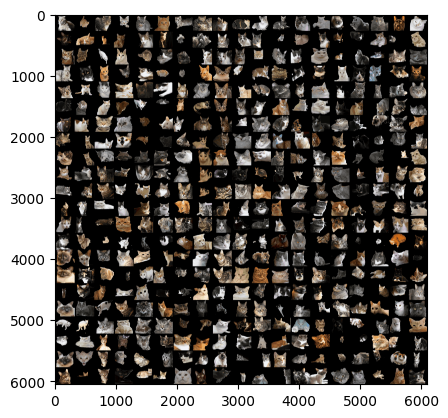

In [8]:
bigimg_comp = compress_colours(kmeans_model, bigimg)
plt.imshow(bigimg_comp/255)

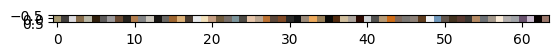

In [12]:
gold_palette = np.array([np.uint8(col) for col in kmeans_model.cluster_centers_
                         if sum(np.uint8(col)>0)])
plt.imshow((gold_palette/255).reshape(1, 64, 3))

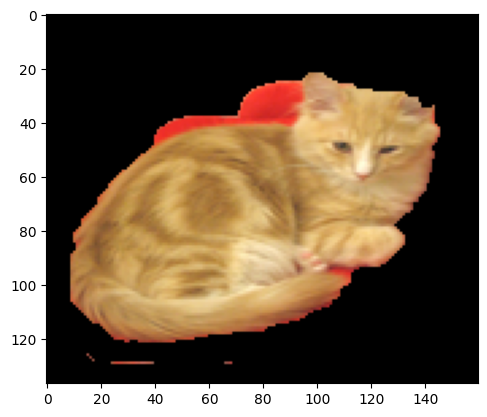

In [5]:
plt.imshow(gen_rois[3])

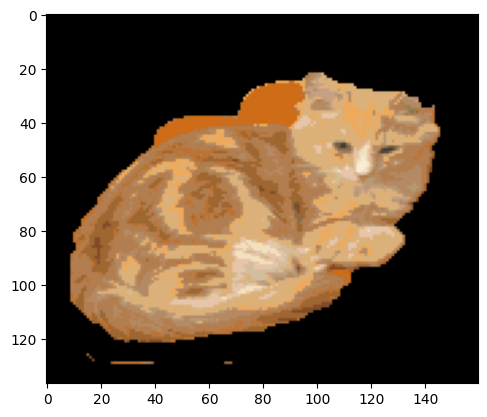

In [6]:
plt.imshow(compress_colours(kmeans_model, gen_rois[3])/255)

In [8]:
from sklearn_col_compressor import get_colour_embedding
c_embed = get_colour_embedding(kmeans_model, gen_rois[3])

In [ ]:
import pandas as pd
a = pd.DataFrame(c_embed.items(), columns=['colours', 'count'], index = ['#%02x%02x%02x' % col for col in c_embed.keys()])
a

,colours,count
#a59871,"(165, 152, 113)",0
#413e3c,"(65, 62, 60)",0
#dddbde,"(221, 219, 222)",0
#876c4b,"(135, 108, 75)",25
#bab8a7,"(186, 184, 167)",0
...,...,...
#a2a5a9,"(162, 165, 169)",0
#68516d,"(104, 81, 109)",0
#c9bace,"(201, 186, 206)",0
#080100,"(8, 1, 0)",0


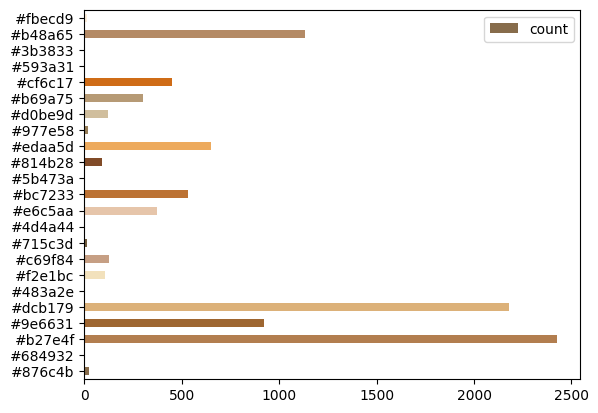

In [11]:
b = a.drop(a[a['count'] == 0].index)
# mycols = np.array([np.array(col)/255 for col in b['colours']])
mycols = np.array([np.array(col)/255 for col in b['colours']])
mycols = ['#%02x%02x%02x' % col for col in b['colours']]

axes = b.plot.barh(color={"count": mycols})

https://www.geeksforgeeks.org/extract-dominant-colors-of-an-image-using-python/

# Unsupervised clustering

In [ ]:
# load the gen image arrays
gen_rois = np.load('./cropped/devroisCAT00.npy')
# compress colours with the fitted method???


In [26]:
raw_imgs = [np.array(Image.open(imgfile).resize((data.avg_size[0]//2,
                                                 data.avg_size[1]//2)))
            for imgfile in data.imgs[:300]]
raw_imgs[0].shape, raw_imgs[0][0][:5]

((275, 321, 3),
 array([[115,  82,  75],
        [113,  89,  76],
        [116,  75,  75],
        [108,  70,  60],
        [109,  70,  56]], dtype=uint8))

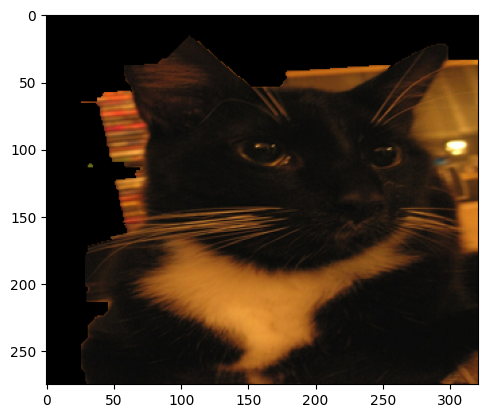

In [56]:
plt.imshow(gen_rois[4])

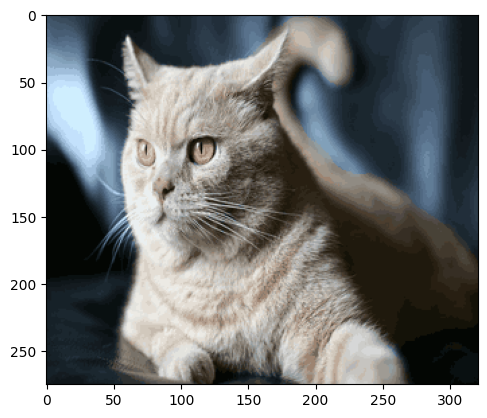

In [74]:
plt.imshow(compress_colours(raw_imgs[4], n_colours=64))

In [8]:
img_ROIs[0].shape, img_ROIs[0][0][:5]

((275, 321, 3),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=uint8))

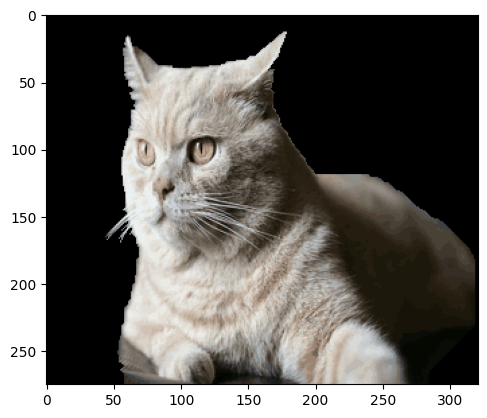

In [10]:
plt.imshow(img_ROIs[3])

In [11]:
ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr
                                   for a in b])))
                for img_arr in img_ROIs]
ROI_palettes = [arr.reshape(1, 64, 3) for arr in ROI_palettes
                if arr.shape==(64, 3)]
ROI_palettes[0].shape, ROI_palettes[0][0][:5]

((1, 64, 3),
 array([[114,  97,  87],
        [ 32,  16,  20],
        [ 83,  65,  65],
        [ 19,  15,  16],
        [171, 169, 167]], dtype=uint8))

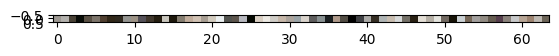

In [12]:
plt.imshow(ROI_palettes[3])

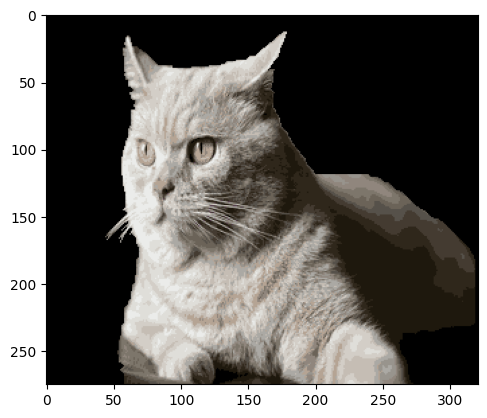

In [13]:
plt.imshow(compress_colours(img_ROIs[3], n_colours=16))

In [14]:
from sklearn.cluster import KMeans

def get_ccluster(ROI_input, n=2, is_pal=False):
    # oct 21, 16:32
    #https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
    # ROI_matrix = np.array([np.uint8(img_arr*255).flatten() for img_arr in ROI_list],
    #                       dtype=np.float32)
    # ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr for a in b])))
    #              for img_arr in ROI_list]
    
            # ROI_palettes = [np.array(list([tuple(a) for b in img_arr for a in b]))
            #             for img_arr in ROI_list]
            
    if is_pal:
        ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr
                                        for a in b])))
                        for img_arr in img_ROIs]
        ROI_list = [arr.reshape(1, 64, 3) for arr in ROI_palettes
                        if arr.shape==(64, 3)]
    else:
        ROI_list=ROI_input
    
    # ROI_feats = list()
    # for img in ROI_list:
    # # print(img.shape)
    #     r_vals, g_vals, b_vals = list(), list(), list()
    #     for a in img:
    #         for col in a:
    #             if col.any():
    #                 r_vals.append(col[0])
    #                 g_vals.append(col[1])
    #                 b_vals.append(col[2])
    #     img_feats = np.array([max(r_vals), min(r_vals), sum(r_vals)/len(r_vals),
    #                     max(g_vals), min(g_vals), sum(g_vals)/len(g_vals),
    #                     max(b_vals), min(b_vals), sum(b_vals)/len(b_vals)])
            
    #     #print(img_feats.shape)
    #     ROI_feats.append(img_feats)
    # else:
    #     ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr for a in b])))
    #              for img_arr in ROI_list]

    #     for img in ROI_palettes:
    #         #print(img.shape)

    #         r_vals, g_vals, b_vals = list(), list(), list()

    #         for col in img:
    #             if col.any():
    #                 r_vals.append(col[0])
    #                 g_vals.append(col[1])
    #                 b_vals.append(col[2])

            
        #  print(len(img))
        # print(max(r_vals), min(r_vals), sum(r_vals)/64, sum(r_vals)/len(r_vals))
        # print(max(g_vals), min(g_vals), sum(g_vals)/64, sum(g_vals)/len(g_vals))
        # print(max(b_vals), min(b_vals), sum(b_vals)/64, sum(b_vals)/len(b_vals))
        # img_feats = np.array([max(r_vals), min(r_vals), sum(r_vals)/len(r_vals),
        #                     max(g_vals), min(g_vals), sum(g_vals)/len(g_vals),
        #                     max(b_vals), min(b_vals), sum(b_vals)/len(b_vals)])
                
        #     #print(img_feats.shape)
        # ROI_feats.append(img_feats)

    ROI_feats = np.array([arr.flatten() for arr in ROI_list])

    # # normalise values
    # ROI_mat /= 255
    # #flat_ROIs = KMeans.fit_transform(flat_ROIs) ??

    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=0)
    Y = kmeans.fit_predict(ROI_feats) #2mins for n=5, 50sec for n=2

    clusters_dict = {cluster_id : list() for cluster_id in set(Y)}
    for i, cluster_id in enumerate(Y):
        clusters_dict[cluster_id].append(ROI_input[i])

    return Y, clusters_dict

In [15]:
Y, clusters = get_ccluster(ROI_palettes, n=2, is_pal=False)
[('cluster nr: '+ str(id), 'items in cluster: '+ str(len(clusters[id]))) for id in set(Y)]


[('cluster nr: 0', 'items in cluster: 122'),
 ('cluster nr: 1', 'items in cluster: 155')]

In [ ]:
def vis_cluster(cluster, n_items=21):
    items = np.array(cluster).reshape(len(cluster), 64, 3)
    #print(cluster.shape)
    # clen = len(cluster)
    # figure, axis = plt.subplots(int(clen/2), 2)
    # figure.set_figwidth(8)
    # figure.set_figheight(15)

    # for i, img in enumerate(items):
    #     if i < int(clen/3):
    #         axis[i][0].imshow(img, interpolation='nearest')
    #     elif i < int(clen/3*2):
    #         axis[i-int(clen/3)][1].imshow(img, interpolation='nearest')
    #     else: 
    #         axis[i-int(clen/3*2)][2].imshow(img, interpolation='nearest')


    plt.imshow(items)

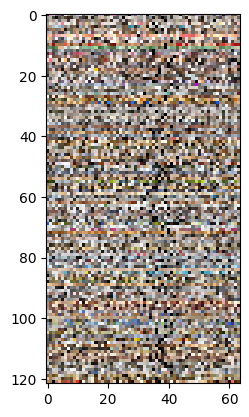

In [17]:
vis_cluster(clusters[0])

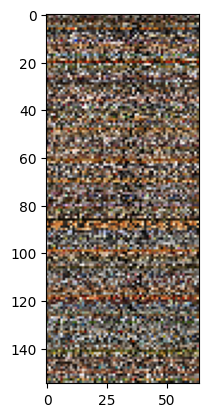

In [18]:
vis_cluster(clusters[1])

In [88]:
vis_cluster(clusters_pal[1])

NameError: name 'clusters_pal' is not defined

In [22]:
# ?? use ggplot in r 
# on clustering https://www.geeksforgeeks.org/clustering-in-machine-learning/

# project https://www.trpkovski.com/2023/10/23/grouping-images-by-colours-exploring-colour-based-image-clustering

In [23]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [24]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
